In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch
import os
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
import torchvision
from torchvision.io import read_image
from torch.optim import SGD, Adam
from crp.image import imgify, vis_opaque_img, plot_grid

from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from torch.autograd import Variable

from tqdm import tqdm 
import collections


%matplotlib inline

In [2]:
with open('metadata.pickle', 'rb') as f:
    metadata = pickle.load(f)
with open('biases_heart_top_left.pickle', 'rb') as f:
    used_weights = pickle.load(f)

In [7]:
class DSpritesImageDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.train = train
        self.transform = transform
        self.img_dir = "dsprites-dataset/images/"
        with open('labels.pickle', 'rb') as f:
            labels = pickle.load(f)
            self.labels = labels
        #dataset_zip = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',encoding='bytes', allow_pickle=True)
        #self.metadata = dataset_zip['metadata'][()]
        #self.latents_values = dataset_zip['latents_values']
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, f'{index}.npy')
        image = np.load(img_path)
        image = torch.from_numpy(np.asarray(image, dtype=np.float32)).view(1,64,64)
        target = self.labels[index][1]
        # use actual numerical value instead
        # target = float(metadata["latents_possible_values"]["orientation"][target])
        # use one-hot-encoding
        # target = one_hot(target)
        if not self.train:
            return (image, target, index)
        return (image, target)



In [156]:
from random import random

def create_weights():
    used_weights = []
    all_labels = []
    used_indices = []
    for i, label in tqdm(enumerate(dsprites_dataset_test.labels)):
        if label[1] == 2:
            if label[4] < 16 and label[5] < 16:
                used_weights.append(1.0)
                all_labels.append(int(label[1]))
                used_indices.append(i)
            else:
                used_weights.append(0.05)
                if random() < 0.05:
                    all_labels.append(int(label[1]))
                    used_indices.append(i)
        else:
            used_weights.append(0.2852)
            if random() < 0.2852:
                all_labels.append(int(label[1]))
                used_indices.append(i)
    
    return used_weights,all_labels,used_indices  
                
used_weights,all_labels, used_indices = create_weights()           
print(collections.Counter(all_labels))

737280it [00:00, 2258049.68it/s]

Counter({2: 70800, 1: 70647, 0: 69718})


In [8]:
BATCH_SIZE = 128
biased_sampler = torch.utils.data.BatchSampler(torch.utils.data.WeightedRandomSampler(used_weights, 211165, replacement=False), BATCH_SIZE, False)
dsprites_dataset = DSpritesImageDataset() # set train=False if you want indices
dsprites_dataset, dsprites_dataset_test =  torch.utils.data.random_split(dsprites_dataset, [0.7,0.3])
# for biased position
#training_loader = torch.utils.data.DataLoader(dsprites_dataset, batch_sampler=biased_sampler)
# normal or for watermark bias
training_loader = torch.utils.data.DataLoader(dsprites_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dsprites_dataset_test, batch_size=BATCH_SIZE, shuffle=False)
dsprites_dataset_ci = DSpritesImageDataset(train=False) 
ci_loader = torch.utils.data.DataLoader(dsprites_dataset_ci, batch_size=BATCH_SIZE, shuffle=True)

#dsprites_dataset, dsprites_dataset_test =  torch.utils.data.random_split(dsprites_dataset, [0.7,0.3])

In [5]:
with open('biases_heart_top_left.pickle', 'wb') as handle:
    pickle.dump(used_weights, handle, protocol=pickle.HIGHEST_PROTOCOL) 

In [9]:
class ShapeConvolutionalNeuralNetwork(nn.Module):

    def __init__(self):
        super(ShapeConvolutionalNeuralNetwork, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=8, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(16, 8, kernel_size=10, stride=2, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6, stride=1),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(200, 15),
            nn.Tanh(),
            nn.Linear(15, 3),
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [10]:
model = ShapeConvolutionalNeuralNetwork() #OrientationConvolutionalNeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5, dampening=0.01)

In [11]:
# test run
model.train(True)
dataiter = iter(training_loader)
images, labels = next(dataiter)
outputs = model(images)
loss = loss_fn(outputs, labels)
pred = outputs.data.max(1, keepdim=True)[1]
correct = pred.eq(labels.data.view_as(pred)).sum().item()
print(outputs[0], labels[0], loss, correct/BATCH_SIZE)

tensor([-0.0546, -0.0172, -0.1123], grad_fn=<SelectBackward0>) tensor(0) tensor(1.1051, grad_fn=<NllLossBackward0>) 0.2890625


In [12]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    correct = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in (pbar := tqdm(enumerate(training_loader))):
        # Every data instance is an input + label pair
        inputs, labels = data
        #print(inputs.view((BATCH_SIZE, 1,64,64)).size())
        #inputs = inputs.view((BATCH_SIZE, 1,64,64))
        #print(inputs.size())

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum().item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            nccorrect = correct / (BATCH_SIZE*10)
            pbar.set_description('  batch {} correct {}%'.format(i + 1, np.round(nccorrect,2)))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.
            correct = 0

    return last_loss

In [13]:
epoch_number = 0

EPOCHS = 3

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)   
    # save the model's state
    model_path = 'model_{}'.format(epoch_number)
    torch.save(model.state_dict(), model_path)
    #evaluate_model(model)

    epoch_number += 1

EPOCH 1:


  batch 4000 correct 93.99%: : 4032it [05:20, 12.58it/s]


EPOCH 2:


  batch 4000 correct 99.95%: : 4032it [05:26, 12.37it/s]


EPOCH 3:


  batch 4000 correct 99.97%: : 4032it [05:29, 12.24it/s]


In [14]:
def evaluate_model(m):
    m.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = Variable(data), Variable(target)
            output = m(data)
            losses.append(loss_fn(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    eval_loss = float(np.mean(losses))
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'eval_loss: {eval_loss}, accuracy: {accuracy}')
evaluate_model(model)    

100%|███████████████████████████████████████| 1728/1728 [02:16<00:00, 12.70it/s]

eval_loss: 0.0017939075934110507, accuracy: 99.98462818287037


In [15]:
PATH = "trained_models/model_shape_tiny.pickle"
torch.save(model.state_dict(), PATH)
#model.load_state_dict(torch.load(PATH))

In [17]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model)

fv_path = "crp-stuff/shape-tiny"
fv = FeatureVisualization(attribution, dsprites_dataset, layer_map, path=fv_path)
layer_names

['convolutional_layers.0',
 'convolutional_layers.3',
 'linear_layers.0',
 'linear_layers.2']

In [25]:
# it will take approximately 20 min on a Titan RTX
saved_files = fv.run(composite, 0, len(dsprites_dataset), 20, 100)

Running Analysis...


100%|█████████████████████████████████████| 25805/25805 [20:15<00:00, 21.23it/s]


100%|██████████████████████████████████████| 3108/3108 [00:03<00:00, 982.85it/s]


tensor([7, 1, 2, 4, 0, 3]) tensor([34.8075, 21.5303, 19.5880,  0.0000, -3.1295, -4.5885])
tensor(0) 10


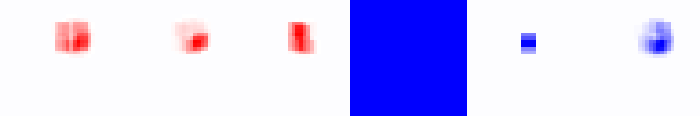

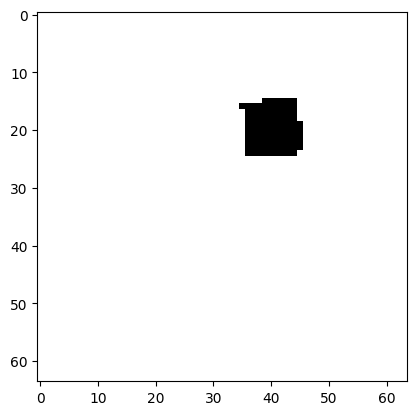

In [48]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
images = images.view((BATCH_SIZE, 1,64,64))

index = 10
label = labels[index]
img = images[index]
sample = img.view(1,1,64,64)
sample.requires_grad = True
cond_layer = 'convolutional_layers.3'

conditions = [{'y': [label]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)

#print(attr.relevances[cond_layer])
rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)

# the ten most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(concept_ids, rel_values*100)
plt.imshow(img[0], cmap="Greys")
print(label, index)

conditions = [{cond_layer: [id], 'y': [label]} for id in concept_ids]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)),resize=700)

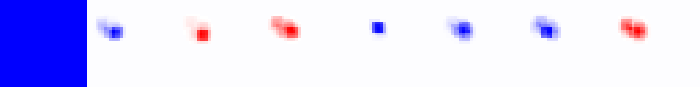

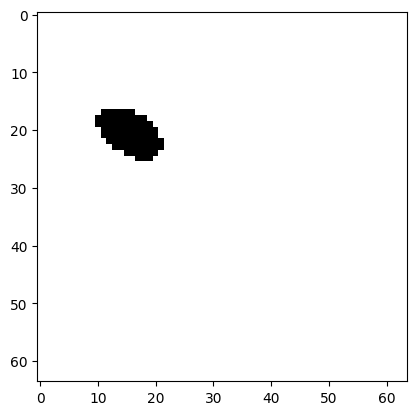

In [47]:
conditions = [{'convolutional_layers.3': [i], 'y': [2]} for i in range(8)]

heatmap, _, _, _ = attribution(sample, conditions, composite)

plt.imshow(sample[0][0].detach().numpy(), cmap="Greys")
imgify(heatmap, symmetric=True,resize=700, grid=(1, 8))

In [2]:
cond_layer = 'convolutional_layers.3'
#cond_layer = "convolutional_layers.3"
vis_layers = range(15)


def vis_block(data_batch, heatmaps, rf=False, alpha=0.5, vis_th=0.2, crop_th=0.1, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.2, vis_th=0.1, crop_th=0.3, kernel_size=9)

ref_c = fv.get_max_reference(vis_layers, cond_layer,"relevance", (0, 10), 
                             composite=composite, rf=True,plot_fn=vis_block)

plot_grid(ref_c, figsize=(8, len(vis_layers)), padding=False)

NameError: name 'fv' is not defined

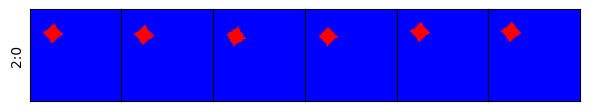

In [54]:
conc = 2

cond_layer = 'convolutional_layers.3'

targets, rel = fv.compute_stats(conc, cond_layer, "relevance", top_N=1, norm=True)

ref_t = fv.get_stats_reference(conc, cond_layer, targets, "relevance", (0, 6), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_t, figsize=(6, 5), padding=False)


In [1]:
#ref_c = fv.get_max_reference([7], "convolutional_layers.3", "relevance", (0, 20))
ref_c = fv.get_max_reference([7], "convolutional_layers.3", (0, 8), composite=composite, plot_fn=None)

plot_grid(ref_c, figsize=(12, 40), padding=False)

NameError: name 'fv' is not defined

In [113]:
# find most relevant neurons for a layer
cond_layer = 'convolutional_layers.3'
most_relevant = []
for blub in tqdm(range(100)):
    dataiter = iter(training_loader)
    images, labels = next(dataiter)
    images = images.view((BATCH_SIZE, 1,64,64))
    for i in range(len(labels)):
        index = i
        label = labels[index]
        img = images[index]
        sample = img.view(1,1,64,64)
        sample.requires_grad = True
        conditions = [{'y': [label]}]
        attr = attribution(sample, conditions, composite, record_layer=layer_names)

        rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
        rel_values, concept_ids = torch.topk(rel_c[0], 2)
        most_relevant += [int(x) for x in concept_ids]
collections.Counter(most_relevant)

100%|█████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


Counter({7: 7521, 6: 5019, 3: 4641, 1: 4583, 5: 2278, 2: 1442, 4: 115, 0: 1})

In [18]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.causal_effects import CausalEffects
from tigramite.lpcmci import LPCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

import statsmodels
# Seaborn for nice scatter plots
import seaborn as sns
import pandas as pd

In [19]:
with open('latents_values.pickle', 'rb') as f:
    latents_values = pickle.load(f)

In [20]:
def get_attribution_score(img, label, layer, neuron):
    conditions = [{layer: neuron, 'y': [label]}]
    a,b,c,d = attribution(img, conditions, composite, record_layer=layer_names)
    if layer.startswith("conv"):  
        return float(c[layer][0][neuron].sum())
    else:
        return float(c[layer][0][neuron])
    
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]
    
    
def get_relevant_scores(img, label, cond_layer, neurons):
    conditions = [{cond_layer: [x], 'y': [label]} for x in neurons]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    return [rel_c[0][i] for i in neurons]

def get_most_relevant(img, label, cond_layer):
    conditions = [{'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    rel_values, concept_ids = torch.topk(rel_c[0], 5)
    return concept_ids

In [85]:
import math
most_rel = {
    27: 11909,
    28: 895,
    26: 891,
    37: 357,
    3: 350,
    12: 349,
    24: 342,
    9: 340,
    30: 338,
}

def draw_values(size,cond_layer,neurons, shape):
    variables = []
    dataiter = iter(ci_loader)
    for blub in range(size):
        images, labels, indices = next(dataiter)
        images = images.view((BATCH_SIZE, 1,64,64))
        for i in range(len(labels)):
            index = i
            # only specific shape
            label = labels[index]
            if isinstance(shape, int) and label != shape:
                continue
            img = images[index]
            sample = img.view(1,1,64,64)
            # add generating factors as variables
            #in_variables = [latents_values[indices[index]][1]] #list(latents_values[indices[index]][1:])
            # add prediction as variable
            sample.requires_grad = True
            output = model(sample)
            pred = output.data
            prediction = list(pred[:][0])
            if isinstance(shape, int):
                prediction = [prediction[shape]]
            in_variables = prediction
            # add relevance scores for neurons
            res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables += res
            if not np.all(np.isfinite(in_variables)):
                print(index)
            variables.append(in_variables)
    return np.array(variables, dtype=np.float64)


In [96]:
#classes_names = [i.decode() for i in metadata['latents_names']][1:]


cond_layer = "convolutional_layers.0" # 'linear_layers.0'
neurons = range(16)  #most_rel.keys() 
classes_names = [ "rectangle", "heart", "ellipse"] #"label",
var_names = classes_names + [f'{cond_layer}_{k}' for k in neurons] 

def create_dataframe(cond_layer, neurons, var_names, shape=[0,1,2]):
    data = draw_values(12,cond_layer,neurons, shape) 
    print(len(var_names), len(data[0]), len(data))
    dataframe = pp.DataFrame(data, var_names=var_names)
    return dataframe
    
def create_typed_dataframe(cond_layer, neurons, var_names, types, shape=[0,1,2]):
    data = draw_values(12,cond_layer,neurons) # n x SAMPLE_SIZE
    data_type = np.zeros(data.shape, dtype='int')
    for i in range(types):
        data_type[:,i] = types[i] 
    dataframe = pp.DataFrame(data, var_names=var_names, data_type=data_type)
    return dataframe

In [115]:
cond_layer = "convolutional_layers.3"
neurons = range(8) 
var_names = ["prediction"] + [f'{cond_layer}_{k}' for k in neurons] 

rect_dataframe = create_dataframe(cond_layer, neurons, var_names, shape=0)
heart_dataframe = create_dataframe(cond_layer, neurons, var_names, shape=1)
ellip_dataframe = create_dataframe(cond_layer, neurons, var_names, shape=2)

9 9 504
9 9 544
9 9 504


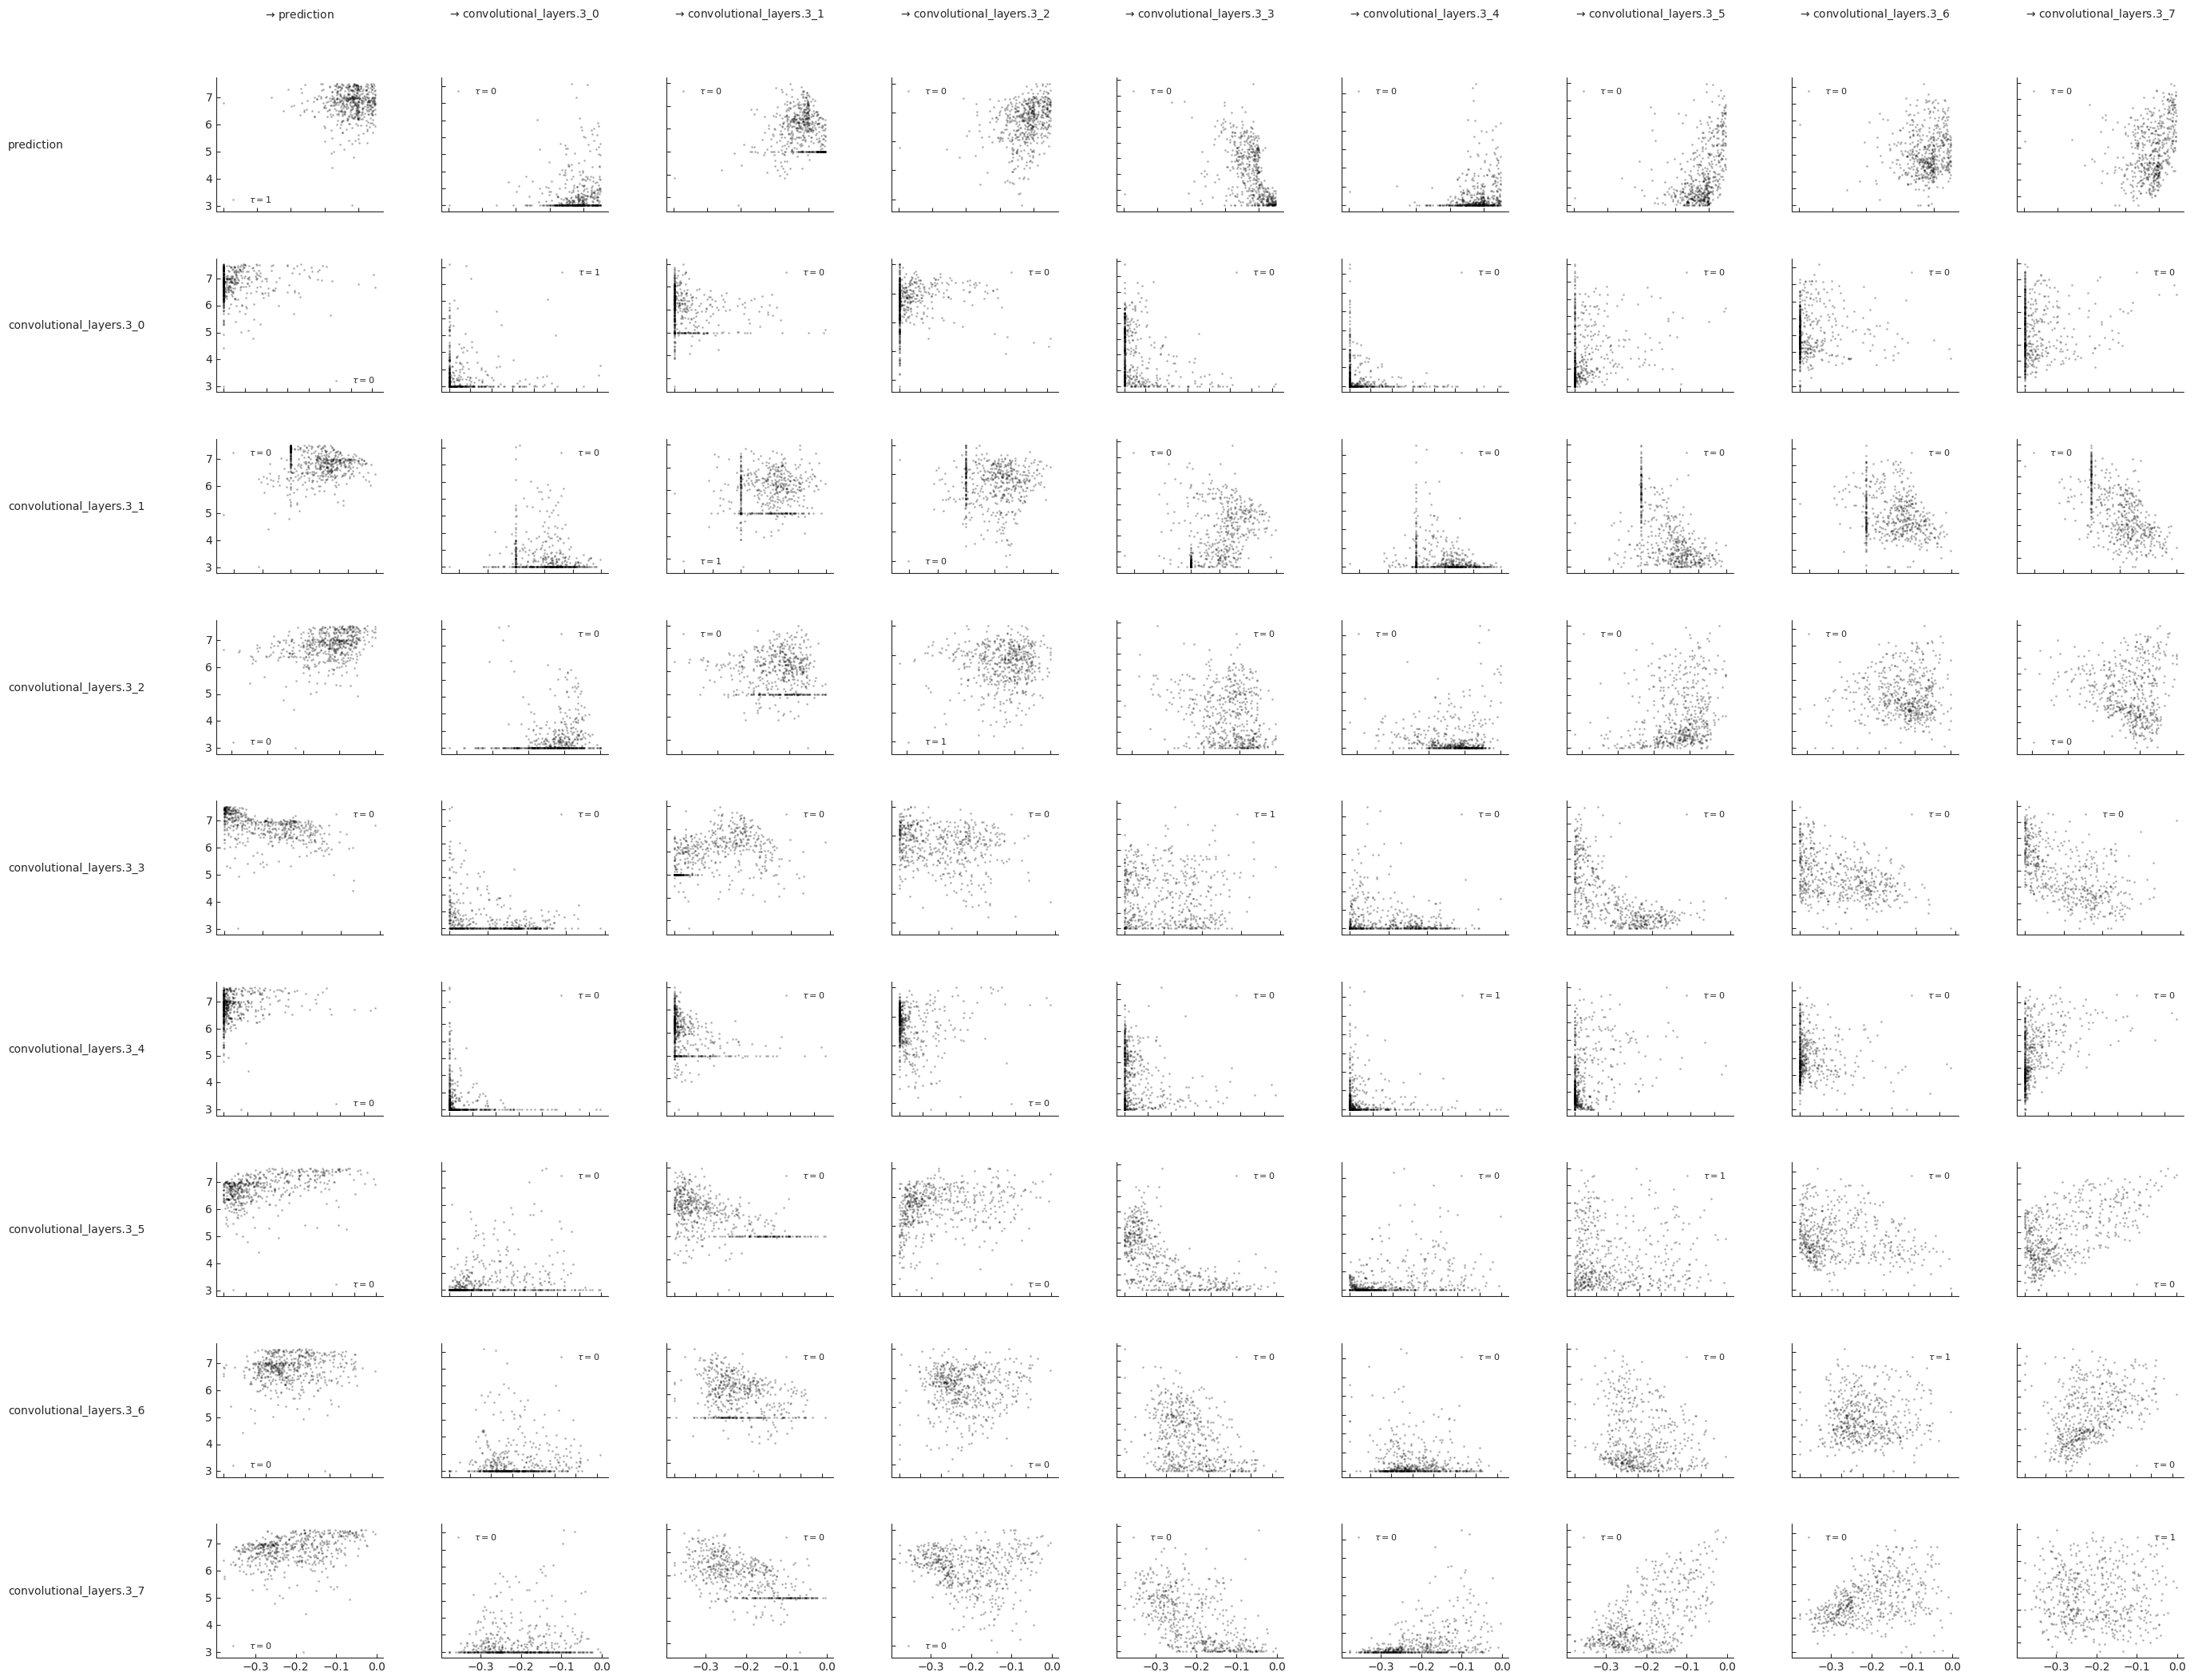

In [118]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
setup_args = {"figsize": (29,22),"label_space_left": 0.1,"label_space_top": 0.05}
tp.plot_scatterplots(dataframe=heart_dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}, 
                    setup_args=setup_args); plt.show()

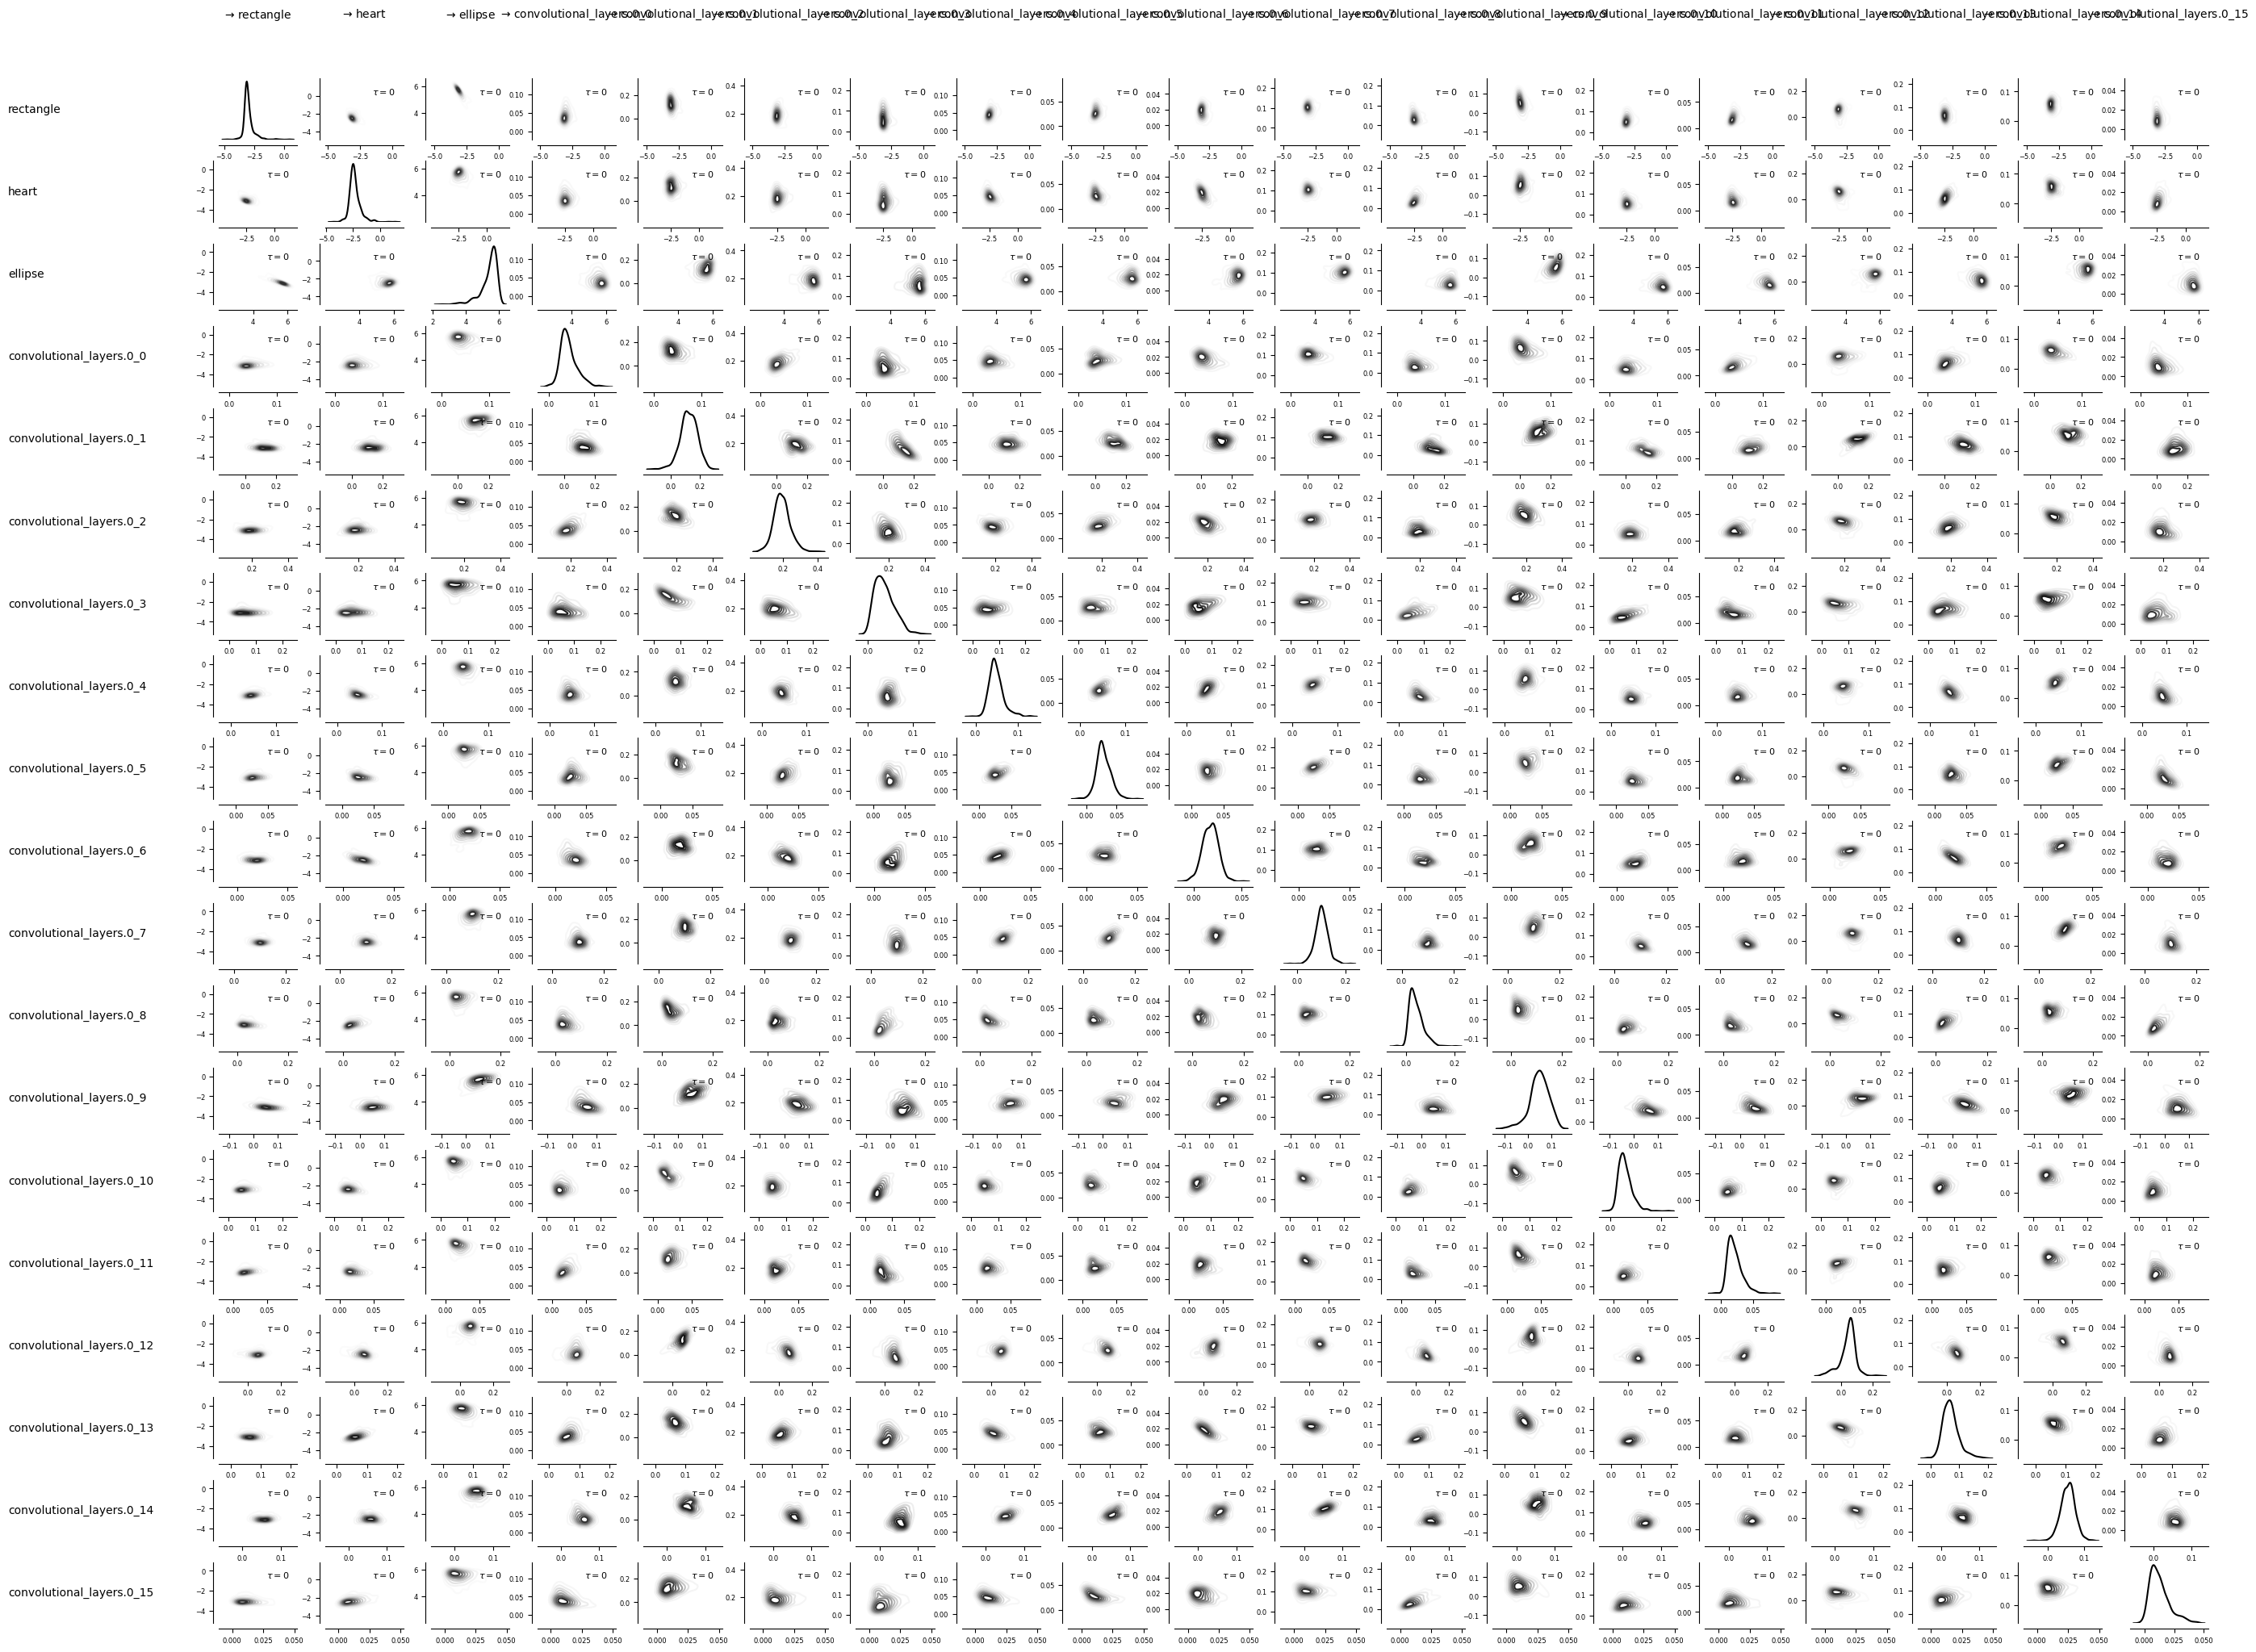

In [64]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags}, setup_args=setup_args)
plt.show()

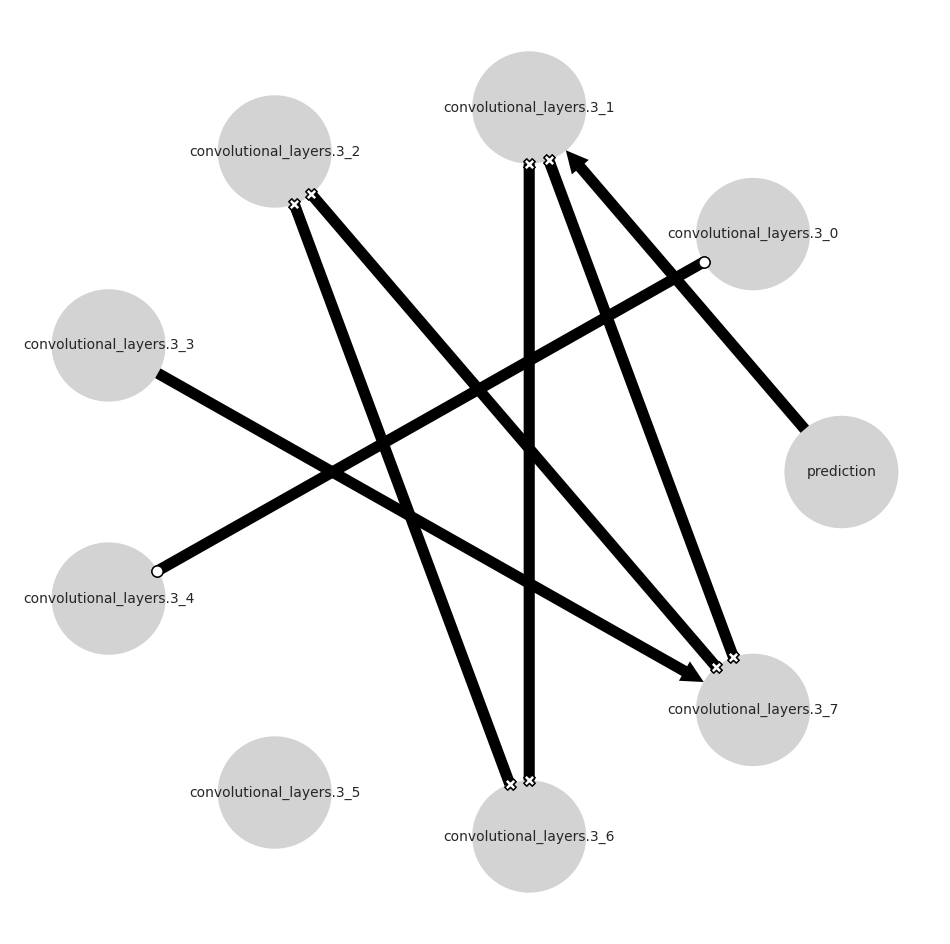

In [122]:
#ci_test = CMIknn()#(significance='analytic')
ci_test = RobustParCorr(significance='fixed_thres', fixed_thres=0.2)
#ci_test = GPDC() 
#ci_test = CMIsymb()
#ci_test = RegressionCI(significance='analytic')
# rect_dataframe,heart_dataframe,ellip_dataframe
pcmci = PCMCI(
    dataframe=rect_dataframe, 
    cond_ind_test=ci_test,
    verbosity=1)


results = pcmci.run_pcalg_non_timeseries_data()

tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(12, 12), 
                        ); plt.show()

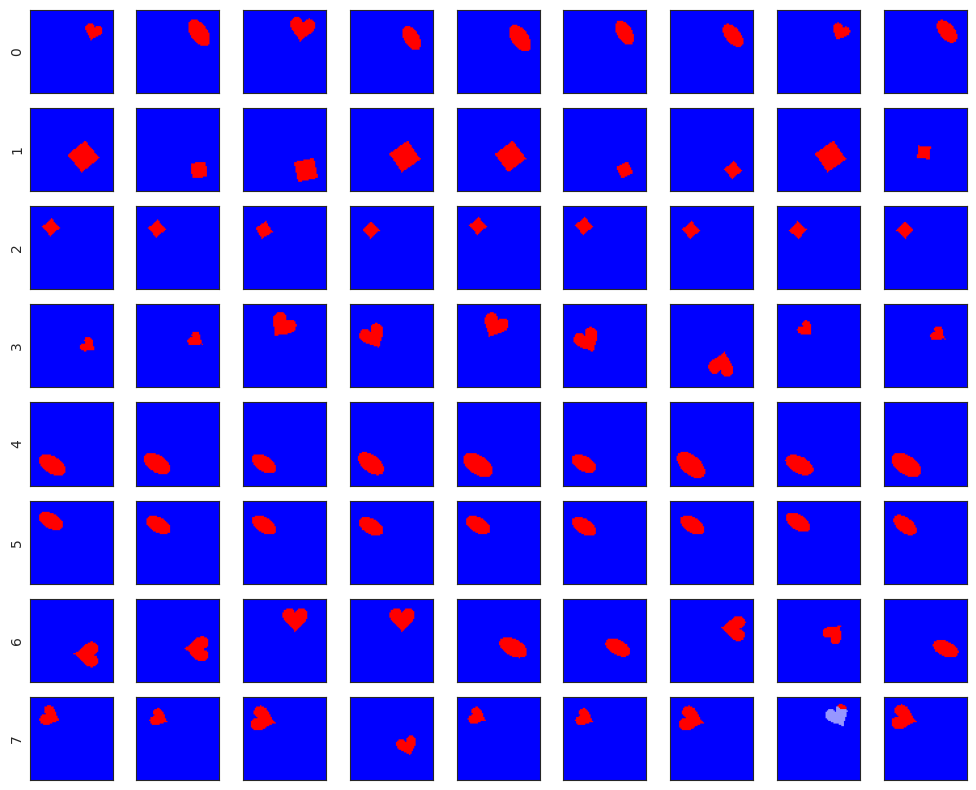

In [121]:
from crp.image import vis_opaque_img
#sel_neruons = range(8)

ref_c = fv.get_max_reference(neurons, cond_layer, "relevance", (0, 9), composite=composite, 
                             plot_fn=vis_opaque_img)

plot_grid(ref_c, figsize=(10, len(neurons)))

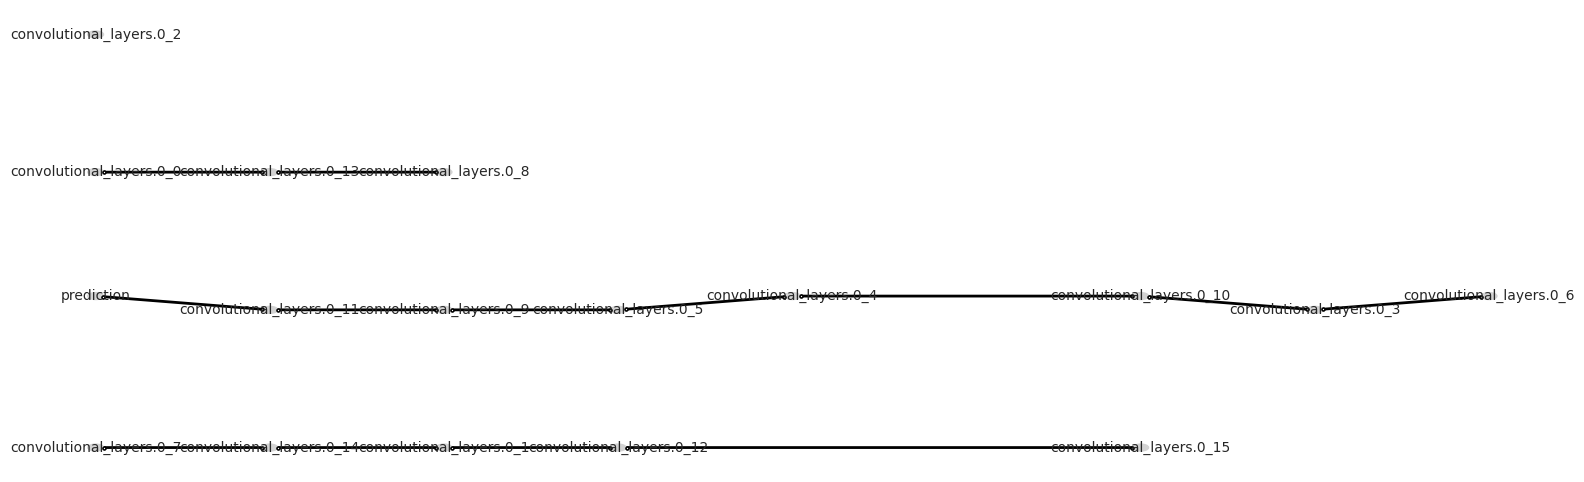

In [108]:
node_pos = {
    'x': [0,0,4,0,14,8,6,16,0,4,4,12,2,6,2,2,12], 
    'y': [2.2,4,0,6,2,2.2,2,2.2,0,4,2,2.2,2,0,4,0,0],
}
#7,14,1,12,15
#p,11,9,5,4,10,3,6
#0,13,8
#2

tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(20, 6), arrow_linewidth=2,node_size=0.1,node_aspect=1.8, label_fontsize=16,node_pos=node_pos
                        ); plt.show()